<a href="https://colab.research.google.com/github/gsuarezr/Qtutorials/blob/master/QMAI_MLQE_2022_day1_part2_Ising_gauge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Table of Contents
* [Part 2.  Ising model with local constraints: Ising lattice gauge theory (ILGT)](#part_2)
    * [Step 1. Import data and analyze the data shape](#Step_1)
    * [Step 2. Dense Neural Network](#Step_2)
        * [Step 2.1 Data pre-processing](#Step_2_1)
        * [Step 2.2 Exercise: Build the DNN](#Step_2_2)
        * [Step 2.3 Training and testing](#Step_2_3)
        
    * [Step 3. Convolutional neural networks (CNNs)](#Step_3)
        * [Step 3.1 Data pre-processing](#Step_3_1)
        * [Step 3.2 Build the CNN](#Step_3_2)
        * [Step 3.3 Training and testing](#Step_3_3)
        * [Step 3.4 Exercise: Analyse and change the model](#Step_3_4)


In [ ]:
####  un-comment this to get data when you run on google colab:
!git clone https://gitlab.com/QMAI/mlqe2022_public.git

Cloning into 'mlqe2022_public'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 263 (delta 122), reused 24 (delta 8), pack-reused 0
Receiving objects: 100% (263/263), 462.89 MiB | 3.66 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Updating files: 100% (71/71), done.


### Part 2. Ising model with local constraints: Ising lattice gauge theory (ILGT) <a class="anchor" id="part_2"></a>

In the previous example, we classified spin configurations of the simple Ising model. That was a relatively easy task given that we know that there's a global order paramter, i.e., the magnetization that distinguishes the two phases the model has.

In the following, we will look at spin configurations coming from a different model on which the dense neural network spectacularly fails. In this model, Ising spins live on the edges of a square lattice (see Figs. below). The Hamiltonian then favors even down and up spins around a square. If the number is odd, a pentalty is paid. The Hamiltonian is given by

\begin{align}
H(\boldsymbol{\sigma}) = -\sum_{p} \prod_{i \in p}\sigma_{i},
\end{align}
where we sum over the plaquettes $p$ of the square lattice.

This model does not have a finite temperature transition. We thus want to train a network to distinguish the (highly degenerate) ground states of this system from any excited state.

Reference:
1. [Greplova, Eliska, et al. "Unsupervised identification of topological phase transitions using predictive models." New Journal of Physics 22.4 (2020): 045003.](https://iopscience.iop.org/article/10.1088/1367-2630/ab7771/meta)



2. [F.W., Duality in generalized Ising models and phase transitions without local order parameter, J. Math. Phys. 12 (1971) 2259](https://aip.scitation.org/doi/abs/10.1063/1.1665530)

In [ ]:
# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Machine learning related libraries:
import torch
import torch.nn as nn            # base class used to develop all neural network models
import torch.nn.functional as F  # module of relu activation functions
import torch.optim as optim      # module of Adam optimizer
# from tqdm import tqdm            # progress meter - wrap any iterable with tqdm(iterable)
from itertools import chain      # append two range() functions
from torch.utils.data import DataLoader # easy and organized data loading to the ML model
from torch.utils.data import Dataset #for nice loadable dataset creation

In [ ]:
####### Detect if running on the clusters  #######
# use CUDA:
torch.cuda.is_available()
print("Is cuda available?", torch.cuda.is_available())

# set a flag
device = torch.device("cuda:0")

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Is cuda available? False
Running on the CPU


First, we load and analyze the shape of our data set again. As before, they are located in the folder `Ising` and labeled by a temperature.

#### Step 1: Import data and analyze the data shape <a class="anchor" id="Step_1"></a>

<!-- The folder `Ising` contains Monte Carlo generated Ising configurations on the two-dimensional lattice. The data set is divided into training and test parts and corresponding label files containing the temperature, $T$, of each Monte Carlo sample. -->

In [ ]:
#### If you run locally by cloning the git "MLQE_2022":
# directory = "Ising"

#### If you run on colab and you clone the data in colab from git "MLQE2022_public":
directory = "mlqe2022_public/day_1/Ising"

In [ ]:
N = 16 # linear dimension of the lattice

ilgt_training_configs = np.load("{0}/ilgt_training_configs.npy".format(directory))
ilgt_training_labels = np.load("{0}/ilgt_training_labels.npy".format(directory))
ilgt_test_configs = np.load("{0}/ilgt_test_configs.npy".format(directory))
ilgt_test_labels = np.load("{0}/ilgt_test_labels.npy".format(directory))
print('train_images.shape =', ilgt_training_configs.shape)
print('train_labels.shape =', ilgt_training_labels.shape)
print('test_images.shape =', ilgt_test_configs.shape)
print('test_labels.shape =', ilgt_test_labels.shape)

train_images.shape = (2000, 16, 16, 2)
train_labels.shape = (2000,)
test_images.shape = (2000, 16, 16, 2)
test_labels.shape = (2000,)


In [ ]:
print(matplotlib.__version__)

#### note the plotting code below doesn't work for matplotlib version higher than 3.5

3.7.1


In [ ]:
def plot_igt_configuration(spins, name, dual=False, save=False):

    '''
    this is just a helper function to plot the configuration of spins  given by 'spins'
    note that (i,j) denotes a vertex coordinate, such that the location of the plaquette
    center is at (i+0.5, j+0.5) and thus, the x spin is at (i+1, j+0.5) etc.

    Parameters
    ----------
    spins  :  int
        spin configuration, dimension is NxNx2
    dual   :  bool
        Plot the configuration in dual space or not. Default is False.
    '''
    N = np.shape(spins)[0]
    fig, ax = plt.subplots()
    ax = fig.axes[0]
#     spins = (2*spins-1)
    for i in range(N+1):
        ax.plot([i, i], [0,N], 'k')
        ax.plot([0,N], [i,i], 'k')

    if not dual:
        colors = ['#1329A4', '#F45A11'] # note: blue is down, gold is up!
        for i in range(N):
            fig.gca().add_patch(plt.Circle((0,i+0.5), radius=0.2, fc=colors[int((spins[-1,2*i]+1)/2.)]))
            fig.gca().add_patch(plt.Circle((i+0.5,0), radius=0.2, fc=colors[int((spins[i,-1]+1)/2.)]))
            for j in range(N):
                fig.gca().add_patch(plt.Circle((i+1,j+0.5), radius=0.2, fc=colors[int((spins[i,2*j+0]+1)/2.)]))
                fig.gca().add_patch(plt.Circle((i+0.5,j+1), radius=0.2, fc=colors[int((spins[i,2*j+1]+1)/2.)]))

    if dual:
        excitation = []
        for i in range(N):
            if spins[-1, 2*i+0]==1: ax.plot([-0.5, 0.5], [i+0.5, i+0.5], '#1329A4', lw=3)
            if spins[i, -1]==1: ax.plot([i+0.5, i+0.5], [-0.5, 0.5], '#1329A4', lw=3)
            for j in range(N):
                j_up = (N+j-1)%N
                i_left = (i+N-1)%N
                if spins[i,2*j+0]==1: ax.plot([i+0.5, i+1.5], [j+0.5, j+0.5], '#1329A4', lw=3)
                if spins[i,2*j+1]==1: ax.plot([i+0.5, i+0.5], [j+0.5, j+1.5], '#1329A4', lw=3)
                if spins[i,2*j+0]*spins[i_left, 2*j+0]*spins[i,2*j+1]*spins[i,2*j_up+1]==-1: excitation.append([i+0.5,j+0.5])
        if len(excitation)>0: plt.scatter(np.array(excitation)[:,0], np.array(excitation)[:,1], color='#F45A11', s=150, marker=(5,1))
    ax.set_ylim(-1,N+1)
    ax.set_xlim(-1,N+1)
    ax.set_aspect('equal')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('off')
    plt.tight_layout()
    if save:
        plt.savefig("configuration_" + name +".pdf")

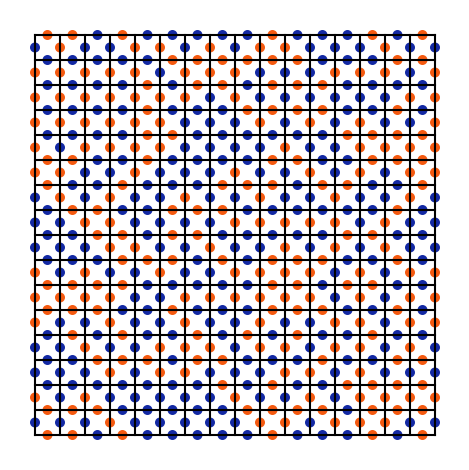

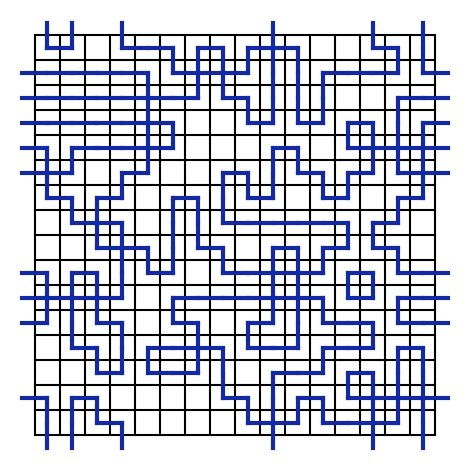

In [ ]:
# reshape data to flatten the two sublattices
N = ilgt_training_configs[0].shape[0]
spins = np.reshape(ilgt_training_configs[0],[N,2*N])

#plt configuration
plot_igt_configuration(spins,'igt0')

#plot the dua mapping
plot_igt_configuration(spins,'igt0_dual',dual=True)
#ax1.set_title("T={:1.2f}".format(ising_training_labels[250]))
#ax1.title.set_position((0.5,-0.1))

#### Step 2. Dense Neural Network <a class="anchor" id="Step_2"></a>

##### Step 2.1 Data pre-processing <a class="anchor" id="Step_2_1"></a>

In [ ]:
### Combine the configuration with their labels:
NUM_TRAINING = len(ilgt_training_labels)    # number of training samples
NUM_TEST = len(ilgt_test_labels)    # number of test samples

REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class datafunc_ilgtConfig():
    # Class that handles the raw data
    def __init__(self, NUM_TRAINING, NUM_TEST):
        #we input the number of training and test samples when initializing the class
        self.NUM_TRAINING = NUM_TRAINING
        self.NUM_TEST = NUM_TEST
        # creat the list that combine the label and ising configurations
        # empty list, will populate data and labels later on
        self.training_data = []
        self.test_data = []

    def make_training_data(self):
        for i in range(self.NUM_TRAINING): # for each sample
            self.training_data.append([ilgt_training_configs[i], ilgt_training_labels[i]]) # combine the config and the phase label
            # uncomment the below if you want your data to be flattened
            # self.training_data.append([ilgt_training_configs[i].flatten(),ilgt_training_labels[i]]) # combine the config and the phase label
        np.random.shuffle(self.training_data)
        np.save("{}/training_data_ilgt.npy".format(directory), np.array(self.training_data, dtype=object))

    def make_test_data(self):
        for i in range(self.NUM_TEST): # for each sample
            self.test_data.append([ilgt_test_configs[i], ilgt_test_labels[i]]) # combine the config and the phase label
            # uncomment the below if you want your data to be flattened
            # self.test_data.append([ilgt_test_configs[i].flatten(),ilgt_test_labels[i]]) # combine the config and the phase label
        np.random.shuffle(self.test_data)
        np.save("{}/test_data_ilgt.npy".format(directory), np.array(self.test_data, dtype=object))

if REBUILD_DATA:
    dataclass_ilgtConfig =  datafunc_ilgtConfig(NUM_TRAINING, NUM_TEST)
    dataclass_ilgtConfig.make_training_data()
    dataclass_ilgtConfig.make_test_data()

# Now we have nice loadable datafile with labels
# load the training and test data:
training_data_ilgt = np.load("{}/training_data_ilgt.npy".format(directory), allow_pickle=True)
test_data_ilgt = np.load("{}/test_data_ilgt.npy".format(directory), allow_pickle=True)

# make them torch tensor
train_X_ilgt = torch.Tensor([i[0] for i in training_data_ilgt])
train_y_ilgt = torch.Tensor([i[1] for i in training_data_ilgt])

test_X_ilgt = torch.Tensor([i[0] for i in test_data_ilgt])
test_y_ilgt = torch.Tensor([i[1] for i in test_data_ilgt])

print("len(train_X_ilgt), len(test_X_ilgt) is ", len(train_X_ilgt), len(test_X_ilgt))

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        # we pass data and labels when we initialize the class
        self.data = data
        self.labels = labels

    def __len__(self):
        # function that outputs length of dataset
        return len(self.data)

    def __getitem__(self, idx):
        # function that outputs data item with index idx
        # return data, label
        data_idx = self.data[idx]
        label = self.labels[idx].type(torch.LongTensor) # label must be output as datatype=Long (also known as int64)
        # note: if you run into error when loading the class, try:
        # label = self.labels[idx][0].type(torch.LongTensor)   #### works for PyTorch 0.4.1.
        # label = self.labels[idx].type(torch.LongTensor)      #### works for PyTorch>=0.5.
        return data_idx, label

# apply CustomDataset() to training dataset
train_dataset_class = CustomDataset(train_X_ilgt, train_y_ilgt)
# apply CustomDataset() to test dataset
test_dataset_class = CustomDataset(test_X_ilgt, test_y_ilgt)

# we pass the dataset as an argument to DataLoader -> automatic batching, sampling, shuffling etc.
batch_size = 32

# create data loaders
train_dataloader = DataLoader(train_dataset_class, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset_class, batch_size = batch_size)

<ipython-input-14-23972e1bbdc9>:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  train_X_ilgt = torch.Tensor([i[0] for i in training_data_ilgt])


len(train_X_ilgt), len(test_X_ilgt) is  2000 2000


In [ ]:
# check that the dataloader works correctly and give the right shape and type
for X, y in train_dataloader:
    print(f"Shape of X: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    # print(X)
    # print(y)
    break

Shape of X: torch.Size([32, 16, 16, 2]) torch.float32
Shape of y: torch.Size([32]) torch.int64


##### Step 2.2 Exercise: Build the DNN <a class="anchor" id="Step_2_2"></a>

In the previous Notebook, we showed how to build a Dense Neural Network.

__Your task__: build a Neural Network that takes as input a configuration and return a binary output: a class for ground state and the other for excited states.

Steps:
- Start create a *Dense_Net* class, that receives as input the torch class "nn.Module";
- inside this class, define a *_ _init_ _* function, in which the layers of the NN are definied:
    - use a "nn.Flatten( )" layer to flatten the images to a 1-dimensional array,
    - define *linear_relu_stack*, using "nn.Sequential( )", made of a sequence of "nn.Linear( )" layers and "nn.ReLU( )" for activation functions (pay attention to specificy the input dimension of the first layer as the  dimension of a flattened configuration image, and the last layer dimension equals to the number of classes of the problem);
- then, define a *forward* function, which uses the layers defined in *_ _ init_ _* to determine how the data will flow through the network.

In [ ]:
###Let's build this dense neural network (DNN)!
### We want (for start) a DNN which takes an input of certain shape
### then let's go with hidden layer of 100 neurons and ReLU
### then output layer (# of neurons = # of classes in the problem)


### YOUR CODE HERE:




# here we initialize an instance of the class
dense_model = Dense_Net().to(device)
print(dense_model)
# print the number of trainable parameters
pytorch_total_params = sum(p.numel() for p in dense_model.parameters())
print(pytorch_total_params)

NameError: name 'Dense_Net' is not defined

##### Step 2.3 Training and testing <a class="anchor" id="Step_2_3"></a>

In [ ]:
# Compile the model with an Adam optimiser
# Take Cross Entropy as a loss function
loss_fn_dnn = nn.CrossEntropyLoss()
optimizer_dnn = torch.optim.Adam(dense_model.parameters(), lr=1e-3)

# define the train and test loss accumulation
train_loss_dnn = []
train_acc_dnn = []
test_loss_dnn = []
test_acc_dnn = []

In [ ]:
# define training function: make predicition on data set batch,
# backpropagate the error and adjust model parameters

def train(dataloader, model, loss_fn, optimizer, train_loss, train_acc):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    model.train()
    running_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        #compute prediction error
        pred = model(X)
        loss = loss_fn(pred,y)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # collect the accuracy:
        running_loss += loss.item()
        correct += (pred.argmax(1)==y).type(torch.float).sum().item()

        if batch % 25==0:
            loss,current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    running_loss /= num_batches
    correct /= size

    train_acc.append(correct)
    train_loss.append(running_loss)

#check performance against the test data set
def test(dataloader,model,loss_fn,test_loss, test_acc):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    running_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            running_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    running_loss /= num_batches
    correct /= size

    test_acc.append(correct)
    test_loss.append(running_loss)
    print(f"Test Error: \n Accuracy {(100*correct):>0.1f}%, Avg loss:{running_loss:>8f}\n")

In [ ]:
# train the DNN only
epochs = 25

for t in range(epochs):
    print(f"Epoch {t+1}\n -------------------")
    train(train_dataloader,dense_model,loss_fn_dnn,optimizer_dnn, train_loss_dnn, train_acc_dnn)
    test(test_dataloader,dense_model,loss_fn_dnn, test_loss_dnn, test_acc_dnn)
print("Done!")

In [ ]:
def create_acc_loss_graph(train_acc,train_loss, test_acc, test_loss):
    fig, axes = plt.subplots(ncols=2, nrows=1, dpi=300)
    fig.set_size_inches(9, 3)
    ax1, ax2 = axes[0], axes[1]

    ax1.plot(train_acc,'-o',label="train", markersize=4)
    ax1.plot(test_acc,'--+',label="test", markersize=4)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc=2)

    ax2.plot(train_loss,'-o',label="train", markersize=4)
    ax2.plot(test_loss,'--+',label=" test", markersize=4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc=2)

    #plot parameters
    ax1.set_ylim(0, 1.25)
#     ax2.set_ylim(0, 1.25)
    ax2.set_ylim(-0.1, np.max([np.max(train_loss),np.max(test_loss)])+0.2)
    ax1.grid(True, which='both',linewidth=0.1)
    ax2.grid(True, which='both',linewidth=0.1)
    plt.tight_layout()
    plt.show()

In [ ]:
create_acc_loss_graph(train_acc_dnn,train_loss_dnn, test_acc_dnn, test_loss_dnn)

#### Step 3. Convolutional Neural Network <a class="anchor" id="Step_3"></a>

We have introduced here a new layer. Lets briefly understand what each layer does.

1.  **Convolutional**: This layer applies 32 kernels of size 2 by 2 over the input image. There are 2 paddings one can choose from 'valid' or 'same'. For our purpose, we need periodic boundary conditions and we thus use 'Valid', which means it does not add additional 'pixels' around the configuration. We instead add the padding ourselves (see below).
```
torch.nn.Conv2d(in_channels = 2, out_channels = 16, kernel_size = 2, stride=1)
```




For more information about layer check out the PyTorch documentation: https://pytorch.org/docs/stable/nn


One final note on the input shape: While for the (first) dense layer we can define just about any shape, the input shape for the convolutional layer is necessarily N x M x C, where C is the number of channels. If the input available has only a single channel, i.e., its shape is N x M, an additional axis with dimension 1 needs to be added for it to work.

Animation: What convolutional layers do?

![Alt Text](https://miro.medium.com/max/789/0*jLoqqFsO-52KHTn9.gif)

The yellow matrix is called a kernel, and its size is one of the hyperparameters. It moves around the green (input) image with step defined by `stride` (here = 1), and how it behaves at the edges of the image is called `padding`. The resulting convolved image is an input to a next layer.

Note that the convolution is performed simultaneously for each channel of the input image, e.g. a color image has C=3 channels, RGB: Red, Green, and Blue. The filters are set to have odd size for practical purpose CxFxF, e.g, 3x3x3, 3x5x5. The output of this operation is one scalar value, an artificial neuron. An illustrative animation for the convolution layer is given in http://cs231n.github.io/convolutional-networks/#conv.
![Alt Text](https://miro.medium.com/max/1100/1*qtinjiZct2w7Dr4XoFixnA.gif)


##### Step 3.1 Data pre-processing: manually adding periodic paddings <a class="anchor" id="Step_3_1"></a>

In [ ]:
kernel_size  = 2
def create_periodic_padding(configs, kernel_size):
    N = np.shape(configs)[1]
    padding = kernel_size-1
    x = []
    for config in configs:
        padded = np.zeros((N+2*padding, N+2*padding, 2))
        # lower left corner
        padded[:padding,:padding, :] = config[N-padding:,N-padding:,:]
        # lower middle
        padded[padding:N+padding, :padding, :] = config[:,N-padding:,:]
        # lower right corner
        padded[N+padding:, :padding, :] = config[:padding, N-padding:, :]
        # left side
        padded[:padding, padding:N+padding, :] = config[N-padding:, :, :]
        # center
        padded[padding:N+padding, padding:N+padding, :] = config[:,:,:]
        # right side
        padded[N+padding:, padding:N+padding, :] = config[:padding, :, :]
        # top left corner
        padded[:padding, N+padding:,:] = config[N-padding:, :padding, :]
        # top middle
        padded[padding:N+padding, N+padding:, :] = config[:, :padding, :]
        # top right corner
        padded[N+padding:, N+padding:, :] = config[:padding, :padding, :]
        x.append(padded)
    return np.array(x)

In [ ]:
# add periodic padding:
kernel_size = 2
ilgt_training_configs_pad = create_periodic_padding(ilgt_training_configs,kernel_size)
ilgt_test_configs_pad = create_periodic_padding(ilgt_test_configs, kernel_size)

In [ ]:
NUM_TRAINING = len(ilgt_training_labels)    # number of training samples
NUM_TEST = len(ilgt_test_labels)    # number of test samples

REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class datafunc_ilgtConfig_pad():
    # Class that handles the raw data
    def __init__(self, NUM_TRAINING, NUM_TEST):
        #we input the number of training and test samples when initializing the class
        self.NUM_TRAINING = NUM_TRAINING
        self.NUM_TEST = NUM_TEST
        # creat the list that combine the label and ising configurations
        # empty list, will populate data and labels later on
        self.training_data = []
        self.test_data = []

    def make_training_data(self):
        for i in range(self.NUM_TRAINING): # for each sample
            config = ilgt_training_configs_pad[i]
            config_sawp_dim = np.einsum('ijk->kji', config)
            #####  np.einsum() change the dimension of a from a(i,j,k) to a(k,i,j)
            self.training_data.append([config_sawp_dim, ilgt_training_labels[i]]) # combine the config and the phase label

        np.random.shuffle(self.training_data)
        np.save("{}/training_data_ilgt_pad.npy".format(directory), np.array(self.training_data, dtype=object))

    def make_test_data(self):
        for i in range(self.NUM_TEST): # for each sample
            config = ilgt_test_configs_pad[i]
            config_sawp_dim = np.einsum('ijk->kji', config)
            #####  np.einsum() change the dimension of a from a(i,j,k) to a(k,i,j)
            self.test_data.append([config_sawp_dim, ilgt_test_labels[i]]) # combine the config and the phase label
        np.random.shuffle(self.test_data)
        np.save("{}/test_data_ilgt_pad.npy".format(directory), np.array(self.test_data, dtype=object))

if REBUILD_DATA:
    dataclass_ilgtConfig_pad = datafunc_ilgtConfig_pad(NUM_TRAINING, NUM_TEST)
    dataclass_ilgtConfig_pad.make_training_data()
    dataclass_ilgtConfig_pad.make_test_data()

# ############################################
# load the training and test data:
training_data_ilgt_pad = np.load("{}/training_data_ilgt_pad.npy".format(directory), allow_pickle=True)
test_data_ilgt_pad = np.load("{}/test_data_ilgt_pad.npy".format(directory), allow_pickle=True)

# make them torch tensor
train_X_ilgt_pad = torch.Tensor([i[0] for i in training_data_ilgt_pad])
train_y_ilgt_pad = torch.Tensor([i[1] for i in training_data_ilgt_pad])

test_X_ilgt_pad = torch.Tensor([i[0] for i in test_data_ilgt_pad])
test_y_ilgt_pad = torch.Tensor([i[1] for i in test_data_ilgt_pad])

print("len(train_X_ilgt_pad), len(test_X_ilgt_pad) is ", len(train_X_ilgt_pad), len(test_X_ilgt_pad))

# apply CustomDataset() to training dataset
train_dataset_pad_class = CustomDataset(train_X_ilgt_pad, train_y_ilgt_pad)
# apply CustomDataset() to test dataset
test_dataset_pad_class = CustomDataset(test_X_ilgt_pad, test_y_ilgt_pad)

# we pass the dataset as an argument to DataLoader -> automatic batching, sampling, shuffling etc.
batch_size = 32

# create data loaders
train_dataloader_pad = DataLoader(train_dataset_pad_class, batch_size = batch_size)
test_dataloader_pad = DataLoader(test_dataset_pad_class, batch_size = batch_size)

len(train_X_ilgt_pad), len(test_X_ilgt_pad) is  2000 2000


##### Step 3.2 Build the CNN <a class="anchor" id="Step_3_2"></a>

In [ ]:
class Conv_Net(nn.Module):
    def __init__(self):
        super(Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=2, stride=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2312, 8)
        # question for students: how do we know the number 2312?
        self.fc2 = nn.Linear(8, 2)

    # x represents our data
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        x = F.relu(x) # Use the rectified-linear activation function over x
        x = torch.flatten(x, 1) # Flatten x with start_dim=1
        x = self.fc1(x) # Pass data through fc1
        x = F.relu(x)
        x = self.fc2(x) # Pass data through fc1
        output = x
        return output

conv_model = Conv_Net().to(device)
print(conv_model)

# print the number of trainable parameters
pytorch_total_params = sum(p.numel() for p in conv_model.parameters())
print(pytorch_total_params)

Conv_Net(
  (conv1): Conv2d(2, 8, kernel_size=(2, 2), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2312, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
)
18594


- How to check the out put size of a conv layer?

- you can use this formula $[(W−K+2P)/S]+1$.
    - $W$ is the input size
    - $K$ is the Kernel size
    - $P$ is the padding
    - $S$ is the stride

In [ ]:

w=18
k=2
p=0
s=1
outsize=(w-k+2*p)/s+1

In [ ]:
out_channel = 8
outsize*outsize*out_channel

2312.0

In [ ]:
out_size = 18-2+1;
out_channel = 8
out_shape = out_size*out_size*out_channel;
print(out_shape)

2312


In [ ]:
# you can use a random tensor to print the out put size of a convelutional layer
# as the sanity check

random_data = torch.rand((1,2, 18, 18))
my_nn = nn.Conv2d(2, 8, 2, 1)
result = my_nn(random_data)
print(len(result.flatten()))
print(result.shape)

2312
torch.Size([1, 8, 17, 17])


##### Step 3.3 Training and testing <a class="anchor" id="Step_3_3"></a>

In [ ]:
loss_fn_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(conv_model.parameters(), lr=1e-3)

train_loss_cnn = []
train_acc_cnn = []
test_loss_cnn = []
test_acc_cnn = []

In [ ]:
def train_cnn(dataloader, model, loss_fn, optimizer, train_loss, train_acc):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    model.train()
    running_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        #compute prediction error
        pred = model(X.view(-1, 2, 18, 18))
        loss = loss_fn(pred,y)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # collect the accuracy:
        running_loss += loss.item()
        correct += (pred.argmax(1)==y).type(torch.float).sum().item()

        if batch % 25==0:
            loss,current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    running_loss /= num_batches
    correct /= size

    train_acc.append(correct)
    train_loss.append(running_loss)

#check performance against the test data set
def test_cnn(dataloader,model,loss_fn,test_loss, test_acc):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    running_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X.view(-1, 2, 18, 18))
            running_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    running_loss /= num_batches
    correct /= size

    test_acc.append(correct)
    test_loss.append(running_loss)
    print(f"Test Error: \n Accuracy {(100*correct):>0.1f}%, Avg loss:{running_loss:>8f}\n")

In [ ]:
# train the CNN
epochs = 50

for t in range(epochs):
    print(f"Epoch {t+1}\n -------------------")
    train_cnn(train_dataloader_pad,conv_model,loss_fn_cnn,optimizer_cnn,train_loss_cnn,train_acc_cnn)
    test_cnn(test_dataloader_pad,conv_model,loss_fn_cnn, test_loss_cnn,test_acc_cnn)
print("Done!")

Epoch 1
 -------------------
loss: 0.675492 [    0/ 2000]
loss: 0.695052 [  800/ 2000]
loss: 0.687846 [ 1600/ 2000]
Test Error: 
 Accuracy 50.0%, Avg loss:0.694364

Epoch 2
 -------------------
loss: 0.679163 [    0/ 2000]
loss: 0.694148 [  800/ 2000]
loss: 0.688897 [ 1600/ 2000]
Test Error: 
 Accuracy 50.0%, Avg loss:0.693834

Epoch 3
 -------------------
loss: 0.680591 [    0/ 2000]
loss: 0.693061 [  800/ 2000]
loss: 0.689313 [ 1600/ 2000]
Test Error: 
 Accuracy 50.0%, Avg loss:0.693682

Epoch 4
 -------------------
loss: 0.683738 [    0/ 2000]
loss: 0.693521 [  800/ 2000]
loss: 0.690355 [ 1600/ 2000]
Test Error: 
 Accuracy 50.0%, Avg loss:0.693394

Epoch 5
 -------------------
loss: 0.686417 [    0/ 2000]
loss: 0.693311 [  800/ 2000]
loss: 0.691187 [ 1600/ 2000]
Test Error: 
 Accuracy 50.1%, Avg loss:0.693230

Epoch 6
 -------------------
loss: 0.685218 [    0/ 2000]
loss: 0.690410 [  800/ 2000]
loss: 0.690750 [ 1600/ 2000]
Test Error: 
 Accuracy 50.1%, Avg loss:0.693219

Epoch 7
 -

In [ ]:
def create_acc_loss_graph(train_acc,train_loss, test_acc, test_loss):
    fig, axes = plt.subplots(ncols=2, nrows=1, dpi=300)
    fig.set_size_inches(9, 3)
    ax1, ax2 = axes[0], axes[1]

    ax1.plot(train_acc,'-o',label="train", markersize=4)
    ax1.plot(test_acc,'--+',label="test", markersize=4)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc=3)

    ax2.plot(train_loss,'-o',label="train", markersize=4)
    ax2.plot(test_loss,'--+',label=" test", markersize=4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc=1)

    #plot parameters
    ax1.set_ylim(0, np.max([np.max(train_acc),np.max(test_acc)])+0.1)
    ax2.set_ylim(-0.1, np.max([np.max(train_loss),np.max(test_loss)])+0.1)
    ax1.grid(True, which='both',linewidth=0.1)
    ax2.grid(True, which='both',linewidth=0.1)
    plt.tight_layout()
    plt.show()

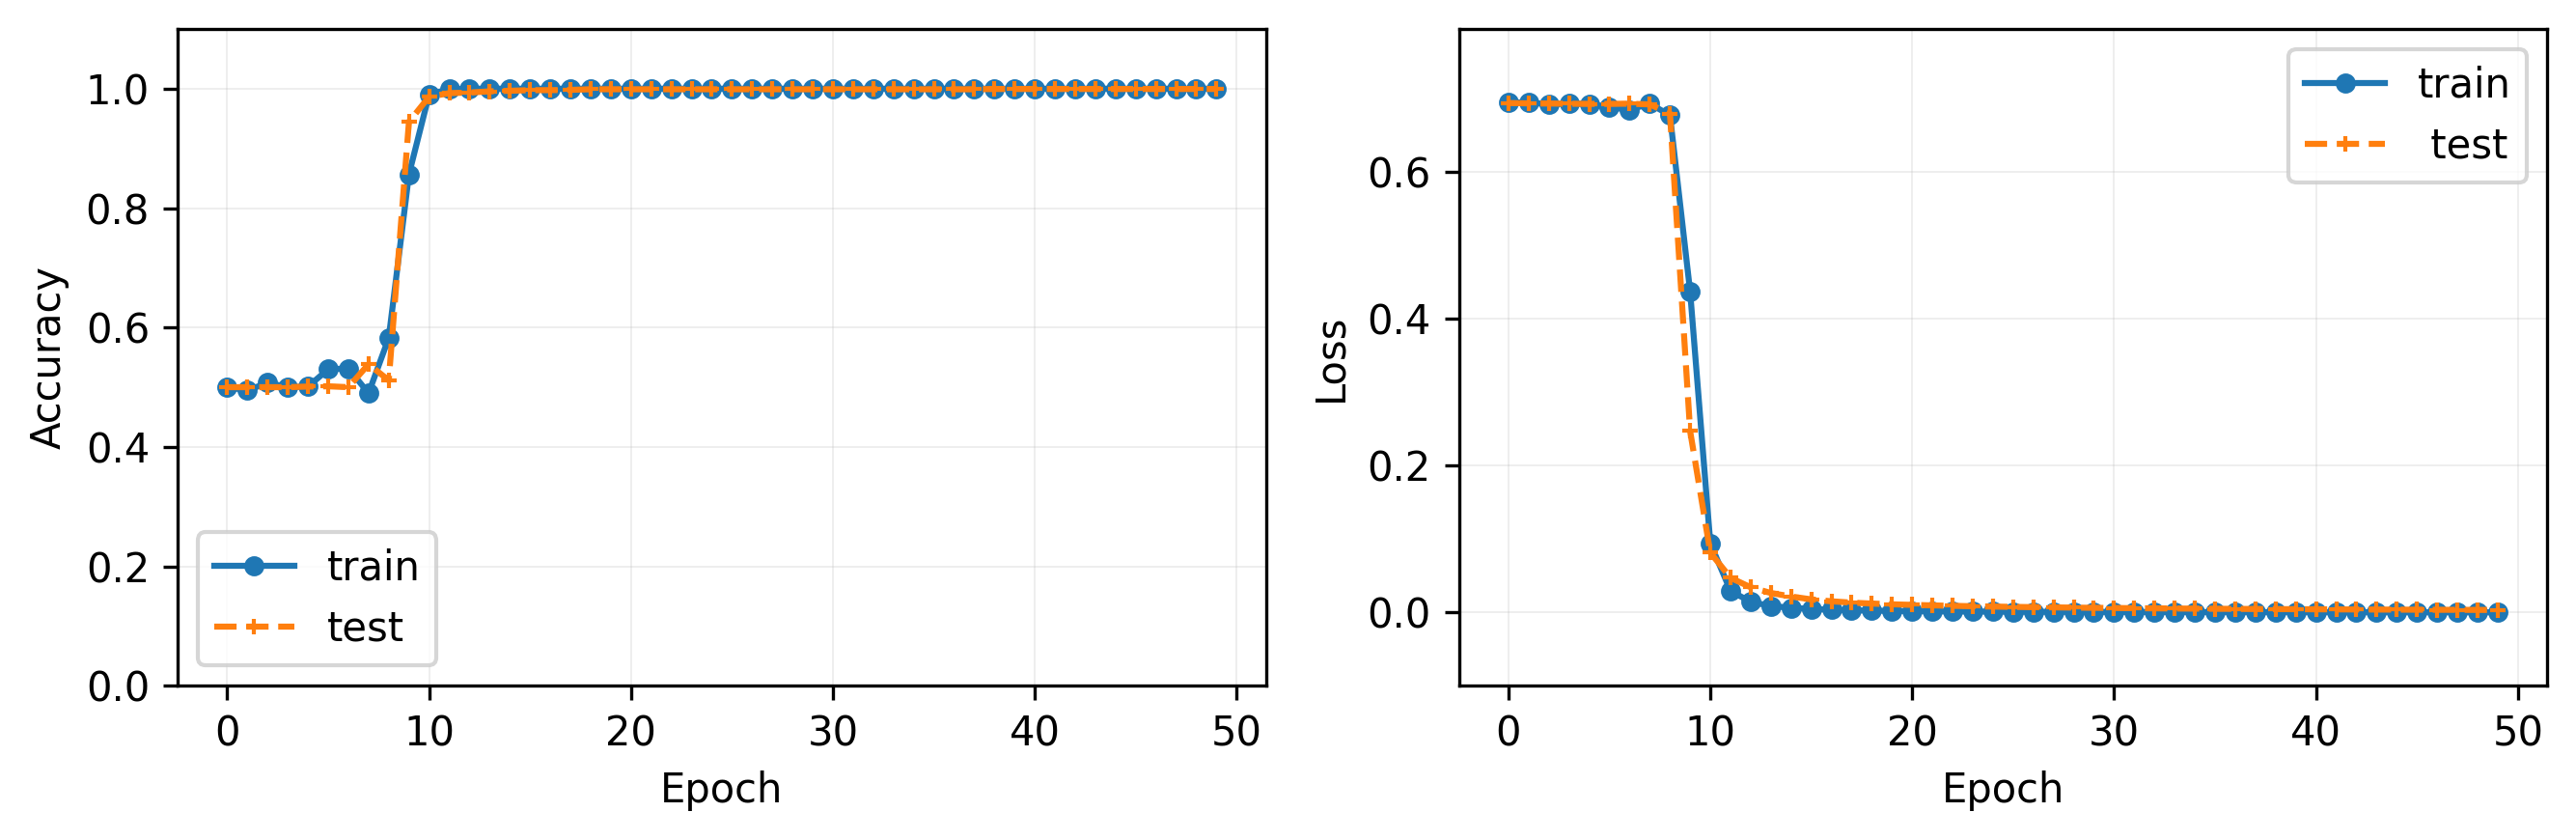

In [ ]:
create_acc_loss_graph(train_acc_cnn,train_loss_cnn, test_acc_cnn, test_loss_cnn)

##### Step 3.4 Exercise: Analyse and change the model  <a class="anchor" id="Step_3_4"></a>

__Question 1:__
In the Convolutional Net built during the previous steps, a kernel with size = (2,2) was used, with a stride of (1,1). Considering the physical model used in this example, can you find a reason why these values for kernel size and stride were choosen?

__Question 2:__
In the first Linear layer used in the Convolutional Network, the input size is 2312. Where does this number come from?

__Task 1:__
Use the cell below to experiment with the network's architecture to gain understanding of its parameters. Add/remove layers and filters.

In [ ]:
class Conv_Net(nn.Module):
    def __init__(self):
        super(Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=2, stride=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2312, 8)
        # question for students: how do we know the number 2312?
        self.fc2 = nn.Linear(8, 2)

    # x represents our data
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        x = F.relu(x) # Use the rectified-linear activation function over x
        x = torch.flatten(x, 1) # Flatten x with start_dim=1
        x = self.fc1(x) # Pass data through fc1
        x = F.relu(x)
        x = self.fc2(x) # Pass data through fc1
        output = x
        return output

conv_model = Conv_Net().to(device)
print(conv_model)

# print the number of trainable parameters
pytorch_total_params = sum(p.numel() for p in conv_model.parameters())
print(pytorch_total_params)